In [15]:
pip install pandapower["all"]

zsh:1: no matches found: pandapower[all]
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pandapower

Note: you may need to restart the kernel to use updated packages.


# STEP 1

In [17]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import math
import geojson
import numpy as np
from openpyxl import load_workbook


## Functions

### Plot with ColorMaps

In [18]:

def plot_colormaps(line_values,bus_values,trafo_values,load_values,file_name):
    
    line_values=net.res_line.loading_percent
    bus_values=net.res_bus.vm_pu
    trafo_values=net.res_trafo.loading_percent
    load_values=net.res_load.p_mw
    switch_values=net.res_switch.i_ka


    cmap_list_line=[(0, "#00e33e"),(50, "yellow"),  (max_line_loading, "red")]
    cmap_list_bus=[(bus_min_pu, "#00e33e"),(1,"yellow"), (bus_max_pu, "red")]
    cmap_list_trafo=[((0, 80), "#00e33e"), ((80, max_trafo_loading), "yellow"), ((max_trafo_loading, 200), "red")]
    cmap_list_load=[(0, "red"), (0.1, "#00e33e")]

    cmap_line, norm_line = plot.cmap_continuous(cmap_list_line)
    cmap_bus, norm_bus= plot.cmap_continuous(cmap_list_bus)
    cmap_trafo, norm_trafo =plot.cmap_discrete(cmap_list_trafo)
    cmap_load, norm_load = plot.cmap_continuous(cmap_list_load)

    load_colors=cmap_load(norm_load(load_values))

    line_c = plot.create_line_collection(net, net.line.index, z=line_values, zorder=1, cmap=cmap_line, norm=norm_line, linewidths=2)
    bus_c = plot.create_bus_collection(net, net.bus.index, z=bus_values, size=0.2, zorder=2, cmap=cmap_bus, norm=norm_bus)
    trafo_c= plot.create_trafo_collection(net, net.trafo.index, z=trafo_values, zorder=3, cmap=cmap_trafo, norm=norm_trafo)
    load_c = plot.create_load_collection(net, net.load.index, size=0.3, color=load_colors)
    
    plot.draw_collections([line_c, bus_c, trafo_c ,load_c], figsize=(15,8))

    # Custom switch plotting
    for i, switch in net.switch.iterrows():
        bus_idx = switch['bus']
        element_idx = switch['element']
        # Get coordinates (assuming the switch connects a bus to a line or another bus)
        bus_coords = net.bus_geodata.loc[bus_idx]
        if bus_idx==14 or bus_idx==7 or bus_idx==4:
            if switch['closed']==1:
                plt.plot(bus_coords.x, bus_coords.y, 'bx', markersize=15)
            else:
                plt.plot(bus_coords.x, bus_coords.y, 'rx',markersize=15)
                
    plt.savefig(file_name)

### Check Voltage Range

In [19]:
def checkVoltageRange(max,min,vm_data,component_name):
    #print(f'---------{component_name} Voltage Check ---------\n')
    i=0
    faults=0
    for vm in vm_data:
        if vm >= max:
            #print(f'{component_name} {i} Voltage is Over the Limit: {round(vm,4)}')
            faults+=1
        elif vm <= min:
            #print (f'{component_name} {i} Voltage is Under the Limit: {round(vm,4)}')
            faults+=1
        elif math.isnan(vm):
            #print (f'{component_name} {i} is off Grid')
            faults+=1
        i+=1
    """if faults==0:
        print(f'OK {component_name} \n')
    else:
        print(f'Number of {component_name} out of Voltage range: {faults}\n ')"""
    return faults   

### Check Loading Percent

In [20]:
def checkLoadingPercent(limit,loading_data,component_name):
    #print(f'---------{component_name} Loading Check ---------\n')
    i=0
    faults=0
    faults_disc=0
    for loading in loading_data:
        if loading > limit:
            #print(f'{component_name}  {i} is Overloaded: {round(loading,2)}')
            faults+=1
        elif math.isnan(loading):
            #print (f'{component_name} {i} is off Grid')
            faults_disc+=1
        i+=1
    """if faults==0:
        print(f'OK {component_name} loading\n')
    else:
        print(f'Number of Overloaded {component_name} : {faults} \n')
        print(f'Number of disconnected {component_name} : {faults_disc} \n')"""
        
    return faults, faults_disc

### Check Load Power

In [21]:
def load_check(load_data):
    #print(f'----------Loads check ---------\n')
    i=0
    faults=0
    load_status=np.zeros(18)
    for load in load_data:
        if load == 0:
            #print(f'{i} OK')
            load_status[i]=1
            faults+=1
        else:
            load_status[i]=0
        i+=1
    """if faults==0:
        print("OK Loads\n")
    else:
        print(f'Number of not served Loads: {faults}\n')"""
    return faults, load_status

### Excel line data

In [22]:
def excel_values_lines(workbook, sheet_name, column_, data, nan_data,power_data):
     # Load the workbook and select the sheet
     sheet = workbook[sheet_name]
     k=0
     # Start writing data
     for i, value in enumerate(data):
          # Start writing from row 5
          row=i+6

          cell = sheet.cell(row=row, column=column_)
          cell.value = value
          cell =sheet.cell(row=row,column=column_+10)
          cell.value= nan_data[k]
          cell =sheet.cell(row=row,column=column_+20)
          cell.value=power_data[k]
          k=k+1

### Excel load data

In [23]:
def excel_values_load(workbook, sheet_name, column_, data):
     # Load the workbook and select the sheet
     sheet = workbook[sheet_name]

     for i, value in enumerate(data):
          # Start writing from row 5
          row=i+5

          cell = sheet.cell(row=row, column=column_)
          cell.value = value
          #print(f"Writing {value} to cell {cell.coordinate}")

### (N-1)Contingency

In [24]:
def contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,l12,l13,l14,file_path):
    workbook = load_workbook(file_path)
    print("------------------------------------------------------------------------------------------------------------------")
    i=0
    sum_line_loading = np.zeros(15)
    sum_line_power=sum_line_loading
    nan_times=sum_line_loading
    sum_load_status=np.zeros(18)
    excel_column=0 
    match (l12,l13,l14):
        case (1, 1, 1):
             excel_column=2
        case (0, 0, 0):
             net.switch.at[1,'closed']=False
             net.switch.at[2,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[13,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=3  
        case (1, 0, 0):
             net.switch.at[2,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[13,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=4
        case (1, 0, 1):
             net.switch.at[2,'closed']=False
             net.line.at[13,'in_service']=False
             excel_column=5
        case (1, 1, 0):
             net.switch.at[5,'closed']=False
             net.line.at[14,'in_service']=False
             excel_column=6
        case (0, 1, 0):
             net.switch.at[1,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=7
        case (0, 1, 1):
             net.switch.at[1,'closed']=False
             net.line.at[12,'in_service']=False
             excel_column=8
        case (0, 0, 1):
             net.switch.at[1,'closed']=False
             net.switch.at[2,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[13,'in_service']=False
             excel_column=9

    print(f'L12 = {l12} L13 = {l13} L14 = {l14} ') 
    for i,line in net.line.iterrows():
        if i < 12:  
            #Printing Line Index and From-To Buses   
            #print(f'######################## Line {i} ##############################')
            from_bus = line['from_bus']
            to_bus = line['to_bus']
            #print(f'From Bus {from_bus} to {to_bus}')

            #Line i Out of service 
            net.line.at[i,'in_service']=False

            #Run the net
            pp.runpp(net)
            #plot_colormaps(net.res_line.loading_percent,net.res_bus.vm_pu,net.res_trafo.loading_percent,net.res_load.p_mw,f'{l12}{l13}{l14}_Line_{i}.png')
            #Check the values
            faults_voltage=checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
            faults_line, faults_disc_line =checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
            faults_trafo, faults_disc_trafo =checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")
            #print(net.res_trafo.loading_percent)
            #print(net.res_trafo.p_hv_mw)
            faults_load,load_status=load_check(net.res_load.p_mw)
            sum_load_status=sum_load_status+load_status

            #Write on Excel
            sheet = workbook['Line_load']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_line)
            sheet=workbook['Line_disc']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_disc_line)
            sheet = workbook['Bus']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_voltage)
            sheet = workbook['Trafo']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_trafo)
            sheet = workbook['Load']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_load)
            
            nan_times=nan_times+ np.where(np.isnan(net.res_line.loading_percent.to_numpy()), 1, 0)
            #print(f'array = {net.res_line.loading_percent.to_numpy()}')
            #print(f'Nan values= {nan_times}')
            sum_line_loading=sum_line_loading+ np.nan_to_num(net.res_line.loading_percent.to_numpy(), nan=0) 
            sum_line_power=sum_line_power+np.nan_to_num(net.res_line.p_from_mw.to_numpy(), nan=0) 
            
            
            net.line.at[i,'in_service']=True
            i+=1

    avg_line_loading= sum_line_loading/(12-nan_times)
    avg_power_loading=sum_line_power/(12-nan_times)
    #print(f'AVG_LINE_LOADING {avg_line_loading}')
    excel_values_lines(workbook,'Line_Loading',excel_column,avg_line_loading,nan_times, avg_power_loading)
    excel_values_load(workbook, 'Load_status',excel_column,sum_load_status)
    workbook.save(file_path)
    net.switch.at[1,'closed']=True
    net.switch.at[2,'closed']=True
    net.switch.at[5,'closed']=True
    net.line.at[12,'in_service']=True
    net.line.at[13,'in_service']=True
    net.line.at[14,'in_service']=True


## 1.1 State of the Network

What is the state of the network? Check bus voltage [pu] and line/transformer loading [%]

Consider that the maximum allowed voltage is 1.1 pu, the minimum is 0.9 pu, and the maximum line loading is 100%.

Set the limits for Voltage Per Unit (pu) and for Line loading

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandapower/plotting/collections.py:1253: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  angle = np.arctan2(vec[1], vec[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandapower/plotting/collections.py:1254: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rotation = Affine2D().rotate_around(pos_sw[0], pos_sw[1], angle)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandapower/plotting/collections.py:1260: FutureWarning: Series.__getitem__ treating keys as positions is depre

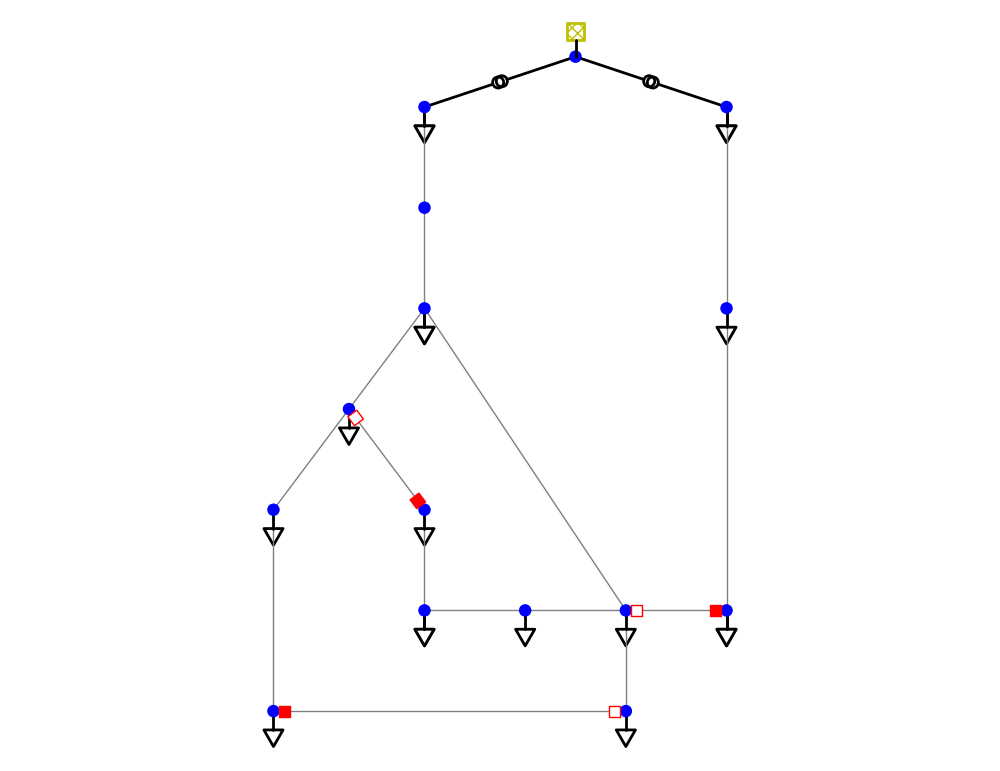

(1, 0)

In [25]:
net = nw.create_cigre_network_mv(with_der=False)

bus_max_pu=1.1
bus_min_pu=0.9
max_line_loading=100
max_trafo_loading=100

pp.runpp(net)
plot.simple_plot(net, respect_switches=False, line_width=1.0, bus_size=1.0, ext_grid_size=1.0, trafo_size=1.0, 
                 plot_loads=True, plot_gens=False, plot_sgens=False, 
                 load_size=2, gen_size=1.0, sgen_size=1.0, 
                 switch_size=2.0, switch_distance=1.0, plot_line_switches=True, scale_size=True, 
                 bus_color='b', line_color='grey', trafo_color='k', ext_grid_color='y', switch_color='r', library='igraph', show_plot=True, ax=None)


checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")

## 1.2 (N-1) Contingency

What happens in the system during a contingency (N-1) case? Are there lines overloaded? Buses above/under the limits?

Consider that the maximum allowed voltage is 1.1 pu, the minimum is 0.9 pu, the maximum line loading is 100% AND all
customers/loads should be supplied with power.

Ignore the switches:
- Line 12 (bus 6 to 7)
- Line 13 (bus 11 to 4)
- Line 14 (bus 14 to 8)

Run the N-1 contingency with the normal limit values for every combination of open/closed switches

In [26]:
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,1,'Step_1.xlsx')

------------------------------------------------------------------------------------------------------------------
L12 = 1 L13 = 1 L14 = 1 
------------------------------------------------------------------------------------------------------------------
L12 = 0 L13 = 0 L14 = 0 
------------------------------------------------------------------------------------------------------------------
L12 = 1 L13 = 0 L14 = 0 


/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 1 L13 = 0 L14 = 1 
------------------------------------------------------------------------------------------------------------------
L12 = 1 L13 = 1 L14 = 0 


/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 0 L13 = 1 L14 = 0 
------------------------------------------------------------------------------------------------------------------
L12 = 0 L13 = 1 L14 = 1 


/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 0 L13 = 0 L14 = 1 


/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


## 1.3 (N-1) Contingency Strict

In [27]:
bus_max_pu=1.05
bus_min_pu=0.95

contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,1,'Step_1_strict.xlsx')

------------------------------------------------------------------------------------------------------------------
L12 = 1 L13 = 1 L14 = 1 
------------------------------------------------------------------------------------------------------------------
L12 = 0 L13 = 0 L14 = 0 
------------------------------------------------------------------------------------------------------------------
L12 = 1 L13 = 0 L14 = 0 


/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 1 L13 = 0 L14 = 1 
------------------------------------------------------------------------------------------------------------------
L12 = 1 L13 = 1 L14 = 0 


/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 0 L13 = 1 L14 = 0 
------------------------------------------------------------------------------------------------------------------
L12 = 0 L13 = 1 L14 = 1 


/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 0 L13 = 0 L14 = 1 


/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:98: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
/var/folders/x0/p9r3gbrs33d9yxhd4qd6kdyh0000gn/T/ipykernel_30827/2958713784.py:99: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


# STEP 2

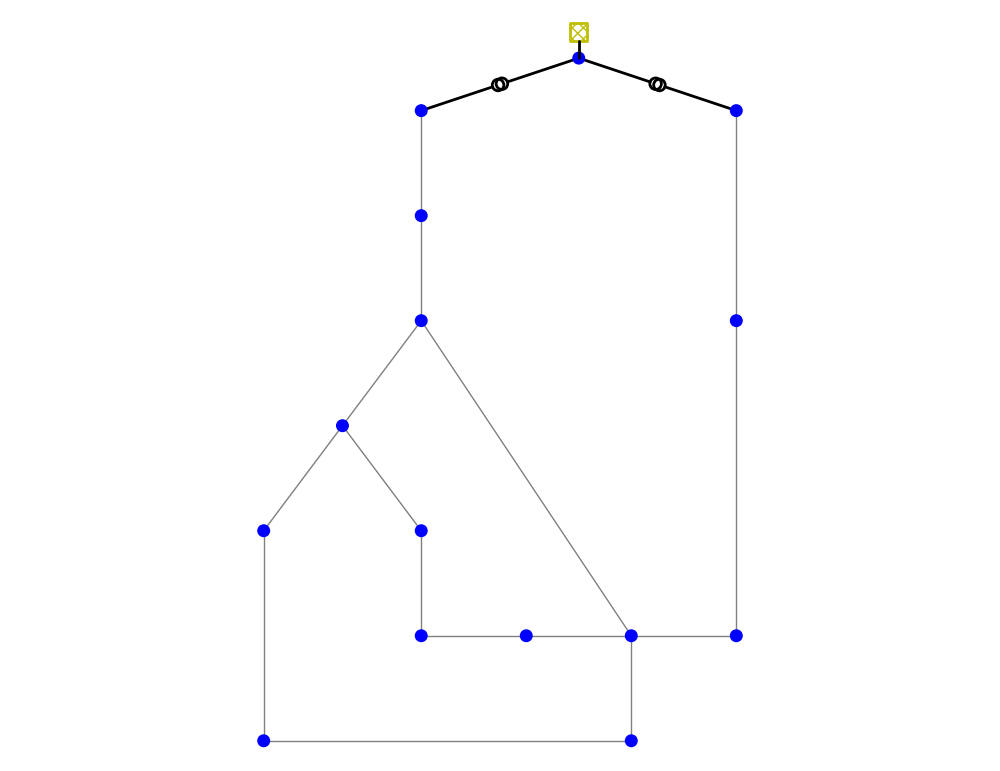

time step 0: Load flow is not converging, check input data or network configuration
time step 1: Load flow is not converging, check input data or network configuration
time step 2: Load flow is not converging, check input data or network configuration
time step 3: Load flow is not converging, check input data or network configuration
time step 4: Load flow is not converging, check input data or network configuration
time step 5: Load flow is not converging, check input data or network configuration
time step 6: Load flow is not converging, check input data or network configuration
time step 7: Load flow is not converging, check input data or network configuration
time step 8: Load flow is not converging, check input data or network configuration
time step 9: Load flow is not converging, check input data or network configuration
time step 10: Load flow is not converging, check input data or network configuration
time step 11: Load flow is not converging, check input data or network conf

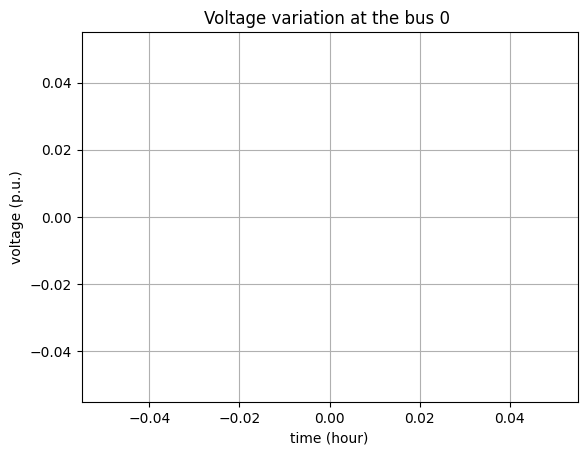

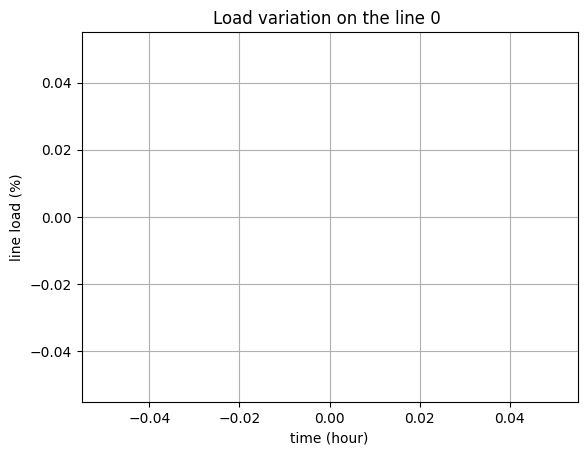

In [28]:
import pandapower as pp
import pandapower.networks as nw
import numpy as np
import matplotlib.pyplot as plt

# Load the CIGRE grid (or use your own)
net = nw.create_cigre_network_mv()
pp.plotting.simple_plot(net, show_plot=True)  # visualisation network

# Adding a 0.4 MVA 20/0.4 kV transformer
hv_bus = 5  # Assuming that the HV busbar number is 5
lv_bus = pp.create_bus(net, vn_kv=0.4, geodata=(0, 6))  # Creating low voltage busbars
pp.create_transformer(net, hv_bus, lv_bus, std_type="0.4 MVA 20/0.4 kV")

# Adding an EV charging station at the low voltage busbar
cs_load = pp.create_load(net, lv_bus, p_mw=0.1, q_mvar=0.02)  # Adding EV Loads

# Given load profile (24 hours)
loadshape = np.array([0.28285, 0.272295, 0.2613828, 0.261328, 0.254316, 0.259789, 0.272966,
                      0.30915, 0.433979, 0.542955, 0.717333, 0.851829, 0.864118, 0.854116,
                      0.853815, 0.852508, 0.723452, 0.490362, 0.428271, 0.361402, 0.336596,
                      0.328176, 0.307331, 0.297966])

# For example, for the R1 load, calculate the daily power curve
p_mw_r1 = 14.99400
q_mvar_r1 = 3.044662
load_profile_r1_p = loadshape * p_mw_r1
load_profile_r1_q = loadshape * q_mvar_r1

# Load scaling factor
scaling_factor = 0.5  # load scaling in half
load_profile_r1_p *= scaling_factor
load_profile_r1_q *= scaling_factor

# Record simulation results
results = []

# Run load flow analyses in 24 time steps
for t in range(len(loadshape)):
    # Update the power value of the R1 load
    net.load.at[cs_load, 'p_mw'] = load_profile_r1_p[t]
    net.load.at[cs_load, 'q_mvar'] = load_profile_r1_q[t]

    # Try to run the load flow and handle possible errors
    try:
        pp.runpp(net, max_iteration=50, tol=1e-5, algorithm='nr')
        print(f"time step {t}: Successful load flow analysis")

        # Storing results (e.g. voltage and line load)
        results.append({
            "time": t,
            "voltages": net.res_bus.vm_pu.values,
            "line_loading": net.res_line.loading_percent.values
        })

    except pp.LoadflowNotConverged:
        print(f"time step {t}: Load flow is not converging, check input data or network configuration")
        # Add invalid results to the list of results to facilitate subsequent analyses
        results.append({
            "time": t,
            "voltages": np.full(len(net.bus), np.nan),  # Denote invalid data by NaN
            "line_loading": np.full(len(net.line), np.nan)
        })

# Visualisation of bus voltage over time
bus_index = 0  # Suppose we want to analyse the bus 0
voltages_over_time = [result["voltages"][bus_index] for result in results]

plt.plot(np.arange(24), voltages_over_time)
plt.xlabel("time (hour)")
plt.ylabel("voltage (p.u.)")
plt.title(f"Voltage variation at the bus {bus_index} ")
plt.grid(True)
plt.show()

# Visualising line loads over time
line_index = 0  # Suppose we want to analyse line 0
line_loading_over_time = [result["line_loading"][line_index] for result in results]

plt.plot(np.arange(24), line_loading_over_time)
plt.xlabel("time (hour)")
plt.ylabel("line load (%)")
plt.title(f"Load variation on the line {line_index} ")
plt.grid(True)
plt.show()
